# Bibliotecas Utilizadas


In [32]:
# Importações completas utilizadas no notebook

# Bibliotecas de manipulação e visualização de dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Bibliotecas de pré-processamento
from sklearn.preprocessing import StandardScaler

# Modelos de aprendizado de máquina
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Ferramentas de avaliação de desempenho
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Métodos de busca de hiperparâmetros e divisão de dados
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Ferramentas estatísticas
from scipy.stats import randint

# Importação dos Dados


In [33]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Dicionário de Dados

| **Coluna**         | **Descrição**                                                                                                                                                   | **Tipo**     |
|---------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------|
| `step`             | Representa uma unidade de tempo no mundo real. Cada passo equivale a 1 hora. O total de passos no dataset é 744 (30 dias de simulação).                       | `int64`      |
| `type`             | Tipo de transação. As categorias incluem: **CASH-IN**, **CASH-OUT**, **DEBIT**, **PAYMENT** e **TRANSFER**.                                                   | `object`     |
| `amount`           | Valor da transação em moeda local.                                                                                                                             | `float64`    |
| `nameOrig`         | Cliente que iniciou a transação.                                                                                                                               | `object`     |
| `oldbalanceOrg`    | Saldo inicial do cliente antes da transação.                                                                                                                   | `float64`    |
| `newbalanceOrig`   | Novo saldo do cliente após a transação.                                                                                                                        | `float64`    |
| `nameDest`         | Cliente que recebeu a transação. Para clientes que começam com "M" (Merchants), não há informações adicionais.                                                 | `object`     |
| `oldbalanceDest`   | Saldo inicial do destinatário antes da transação. Não há informações para destinatários que começam com "M" (Merchants).                                       | `float64`    |
| `newbalanceDest`   | Novo saldo do destinatário após a transação. Não há informações para destinatários que começam com "M" (Merchants).                                            | `float64`    |
| `isFraud`          | Indica se a transação foi identificada como fraudulenta (1 para fraude, 0 para não fraude). Fraudes simuladas tentam esvaziar contas por transferência ou saque.| `int64`      |
| `isFlaggedFraud`   | Marca tentativas ilegais de transferência acima de 200.000 em uma única transação (1 para tentativa ilegal, 0 caso contrário).                                | `int64`      |

---

# Visualização dos Dados

In [34]:
# Verificar o número de linhas e colunas do DataFrame
rows, columns = df.shape
print(f"O DataFrame possui {rows} linhas e {columns} colunas.")

O DataFrame possui 6362620 linhas e 11 colunas.


In [35]:
# Verificar colunas com valores nulos e exibi-las
missing_data_info = df.isnull().sum().sort_values(ascending=False)
missing_data_df = pd.DataFrame({
    'Coluna': missing_data_info.index,
    'Valores Ausentes': missing_data_info.values,
    'Percentual (%)': (missing_data_info.values / len(df)) * 100
})

# Filtrar apenas colunas com valores ausentes
missing_data_df = missing_data_df[missing_data_df['Valores Ausentes'] > 0]
print(missing_data_df)

Empty DataFrame
Columns: [Coluna, Valores Ausentes, Percentual (%)]
Index: []


In [36]:
# Verificar duplicatas
duplicate_rows = df.duplicated().sum()
print(f"Número de linhas duplicadas: {duplicate_rows}")

# Remover duplicatas, se existirem
df = df.drop_duplicates()

Número de linhas duplicadas: 0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Etapa 1: Análise Exploratória

A análise exploratória tem como objetivo compreender as características do conjunto de dados, identificar padrões e possíveis problemas, como valores ausentes ou outliers. Serão apresentados gráficos, tabelas e estatísticas descritivas para apoiar a interpretação dos dados.

### Descrição do Conjunto de Dados
- Identificação do número de amostras e variáveis.
- Verificação de valores ausentes e possíveis inconsistências.
- Distribuição das classes (fraudulenta vs. não fraudulenta).

### Estatísticas Descritivas
- Análise das medidas estatísticas básicas, como média, mediana, desvio padrão e quartis.
- Verificação de outliers e variáveis que necessitam de transformação.

### Análise Gráfica
- Visualização da distribuição das variáveis.
- Identificação de correlações entre as variáveis do dataset.


In [38]:
# Exibe a distribuição das classes na coluna 'isFraud'
print("\nDistribuição das classes (fraudulenta vs. não fraudulenta):")
print(df['isFraud'].value_counts())

# Exibe a quantidade de fraudes usando uma f-string
fraudes = df['isFraud'].value_counts()[1]  # Obtém o número de fraudes (classe 1)
print(f"O número total de transações fraudulentas é: {fraudes}")


Distribuição das classes (fraudulenta vs. não fraudulenta):
isFraud
0    6354407
1       8213
Name: count, dtype: int64
O número total de transações fraudulentas é: 8213


In [39]:
# Exibe a distribuição das classes na coluna 'isFraud'
print("\nDistribuição das classes (fraudulenta Sinalizada vs. não fraudulenta Sinalizada):")
print(df['isFlaggedFraud'].value_counts())

# Exibe a quantidade de fraudes usando uma f-string
fraudes = df['isFlaggedFraud'].value_counts()[1]  # Obtém o número de fraudes (classe 1)
print(f"O número total de transações fraudulentas Sinalizadas é: {fraudes}")


Distribuição das classes (fraudulenta Sinalizada vs. não fraudulenta Sinalizada):
isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64
O número total de transações fraudulentas Sinalizadas é: 16


In [40]:
# Calcular o valor total no campo 'amount'
total_amount = df['amount'].sum()

# Exibir o valor total no campo 'amount' com uma f-string
print(f"O valor total no campo 'amount' é de R$ {total_amount:,.2f}")

O valor total no campo 'amount' é de R$ 1,144,392,944,759.77


In [41]:
# Calcular o valor total fraudado
total_fraud_amount = df[df['isFraud'] == 1]['amount'].sum()

# Exibir o valor total fraudado com uma f-string
print(f"O valor total fraudado é de R$ {total_fraud_amount:,.2f}")

O valor total fraudado é de R$ 12,056,415,427.84


In [42]:
# Calcular o valor total fraudado
total_fraud_amount = df[df['isFlaggedFraud'] == 1]['amount'].sum()

# Exibir o valor total fraudado com uma f-string
print(f"O valor total fraudado sinalizado é de R$ {total_fraud_amount:,.2f}")

O valor total fraudado sinalizado é de R$ 77,785,563.69


In [43]:
# Contar os tipos de transações fraudulentas no DataFrame
fraud_type_counts = df[df['isFlaggedFraud'] == 1]['type'].value_counts()

# Exibir os valores de cada tipo de transação fraudulenta
for transaction_type, count in fraud_type_counts.items():
    print(f"O tipo de transação '{transaction_type}' tem {count} casos de fraude sinalizada.")

O tipo de transação 'TRANSFER' tem 16 casos de fraude sinalizada.


In [44]:
# Contar os tipos de transações fraudulentas no DataFrame
fraud_type_counts = df[df['isFraud'] == 1]['type'].value_counts()

# Exibir os valores de cada tipo de transação fraudulenta
for transaction_type, count in fraud_type_counts.items():
    print(f"O tipo de transação '{transaction_type}' tem {count} casos de fraude.")

O tipo de transação 'CASH_OUT' tem 4116 casos de fraude.
O tipo de transação 'TRANSFER' tem 4097 casos de fraude.


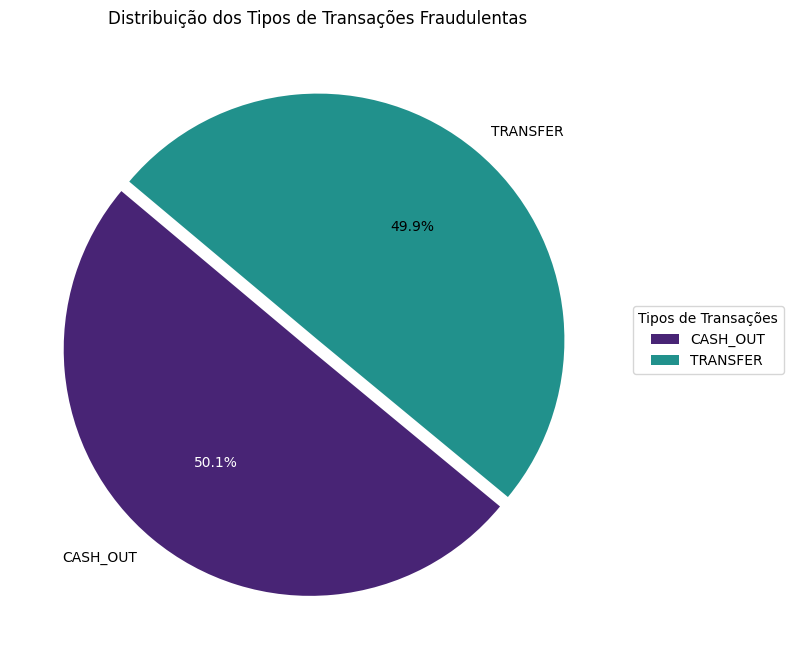

In [45]:
# Ajustar cores e destacar a fatia correspondente ao tipo mais frequente
colors = plt.cm.viridis([0.1, 0.5, 0.9])  # Paleta de cores personalizada
explode = [0.05 if i == fraud_type_counts.idxmax() else 0 for i in fraud_type_counts.index]  # Destaque para a maior fatia

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    fraud_type_counts,
    labels=fraud_type_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode
)

# Alterar a cor do texto no gráfico de pizza
for i, autotext in enumerate(autotexts):
    if fraud_type_counts.index[i] == fraud_type_counts.idxmax():  # Ajusta a cor apenas para a maior fatia
        autotext.set_color("white")
    else:
        autotext.set_color("black")

# Configurar legenda fora do gráfico
plt.legend(wedges, fraud_type_counts.index, title="Tipos de Transações", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title('Distribuição dos Tipos de Transações Fraudulentas')
plt.show()

## Etapa 2: Modelagem

Nesta etapa, os dados serão divididos em conjuntos de treino e teste, e modelos de Machine Learning serão treinados utilizando os algoritmos KNN, Árvore de Decisão e Regressão Logística. Os resultados de cada modelo serão comparados com base nas métricas de desempenho.

### Preparação dos Dados
- Separação das variáveis independentes (features) e dependente (target).
- Normalização ou padronização das variáveis, se necessário.
- Divisão do conjunto de dados em treino (70%) e teste (30%).

### Construção dos Modelos
- Treinamento e avaliação do modelo KNN.
- Treinamento e avaliação do modelo Árvore de Decisão.
- Treinamento e avaliação do modelo Regressão Logística.


In [46]:
# Remover colunas irrelevantes
columns_to_drop = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'nameOrig', 'nameDest']
df_cleaned = df.drop(columns=columns_to_drop, axis=1)

# Separar features (X) e target (y)
X = df_cleaned.drop('isFraud', axis=1)
y = df_cleaned['isFraud']

# Codificar a variável categórica 'type' usando One-Hot Encoding
X = pd.get_dummies(X, columns=['type'], drop_first=True)

# Converter colunas booleanas para int (se necessário)
X = X.astype(int)

# Dividir o conjunto de dados em treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalizar ou padronizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
# Verificando o Tipo dos Dados do X
print(X.dtypes)

step              int64
amount            int64
isFlaggedFraud    int64
type_CASH_OUT     int64
type_DEBIT        int64
type_PAYMENT      int64
type_TRANSFER     int64
dtype: object


In [48]:
# Verificando o Tipo dos Dados do y
print(y.dtypes)

int64


In [49]:
# Subamostrar para reduzir o conjunto de treinamento
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=0.1, stratify=y_train, random_state=42
)

# Reduzir dimensionalidade com PCA
max_components = min(X_train_sample.shape[1], X_test.shape[1])
n_components = min(10, max_components)
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train_sample)
X_test_pca = pca.transform(X_test)


# Inicializar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Treinar o modelo
start_time = time.time()
knn.fit(X_train_pca, y_train_sample)
train_time = time.time() - start_time
print(f"Tempo de treinamento (KNN tradicional): {train_time:.2f} segundos")

# Fazer previsões
start_time = time.time()
y_pred_knn = knn.predict(X_test_pca)
predict_time = time.time() - start_time
print(f"Tempo de previsão (KNN tradicional): {predict_time:.2f} segundos")

# Avaliação
#print("Acurácia (KNN tradicional):", accuracy_score(y_test, y_pred_knn))
#print("\nRelatório de classificação (KNN tradicional):\n", classification_report(y_test, y_pred_knn))

Tempo de treinamento (KNN tradicional): 1.24 segundos
Tempo de previsão (KNN tradicional): 134.51 segundos


In [50]:
# Inicializar o modelo de Árvore de Decisão
dt = DecisionTreeClassifier(random_state=42)

# Medir o tempo de treinamento
start_train = time.time()
dt.fit(X_train, y_train)
train_time = time.time() - start_train
print(f"Tempo de treinamento (Árvore de Decisão): {train_time:.2f} segundos")

# Medir o tempo de previsão
start_predict = time.time()
y_pred_dt = dt.predict(X_test)
predict_time = time.time() - start_predict
print(f"Tempo de previsão (Árvore de Decisão): {predict_time:.2f} segundos")

# Avaliar o desempenho
#print("\nÁrvore de Decisão - Classification Report:")
#print(classification_report(y_test, y_pred_dt))

Tempo de treinamento (Árvore de Decisão): 35.79 segundos
Tempo de previsão (Árvore de Decisão): 0.23 segundos


In [51]:
# Inicializar o modelo de Regressão Logística
lr = LogisticRegression(random_state=42, max_iter=1000)

# Medir o tempo de treinamento
start_train = time.time()
lr.fit(X_train, y_train)
train_time = time.time() - start_train
print(f"Tempo de treinamento (Regressão Logística): {train_time:.2f} segundos")

# Medir o tempo de previsão
start_predict = time.time()
y_pred_lr = lr.predict(X_test)
predict_time = time.time() - start_predict
print(f"Tempo de previsão (Regressão Logística): {predict_time:.2f} segundos")

# Avaliar o desempenho
#print("\nRegressão Logística - Classification Report:")
#print(classification_report(y_test, y_pred_lr))

Tempo de treinamento (Regressão Logística): 4.83 segundos
Tempo de previsão (Regressão Logística): 0.04 segundos


## Etapa 4: Identificação das Features Mais Importantes

Será feita a análise das variáveis mais relevantes para o modelo, explicando quais delas contribuem de forma significativa para a detecção de fraudes.


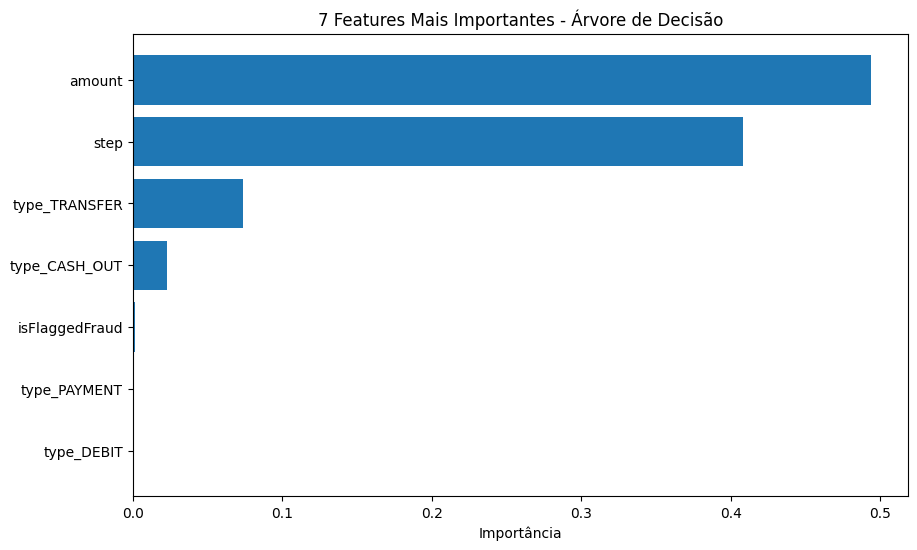

In [52]:
# Importância das features no modelo de Árvore de Decisão

# Extrair importância das features
feature_importances = dt.feature_importances_
features = X.columns

# Ordenar as features pela importância
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Ajustar o número máximo de features a exibir
top_n = min(10, len(sorted_features))

# Visualizar as features mais importantes
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:top_n], sorted_importances[:top_n])
plt.gca().invert_yaxis()
plt.title(f"{top_n} Features Mais Importantes - Árvore de Decisão")
plt.xlabel("Importância")
plt.show()

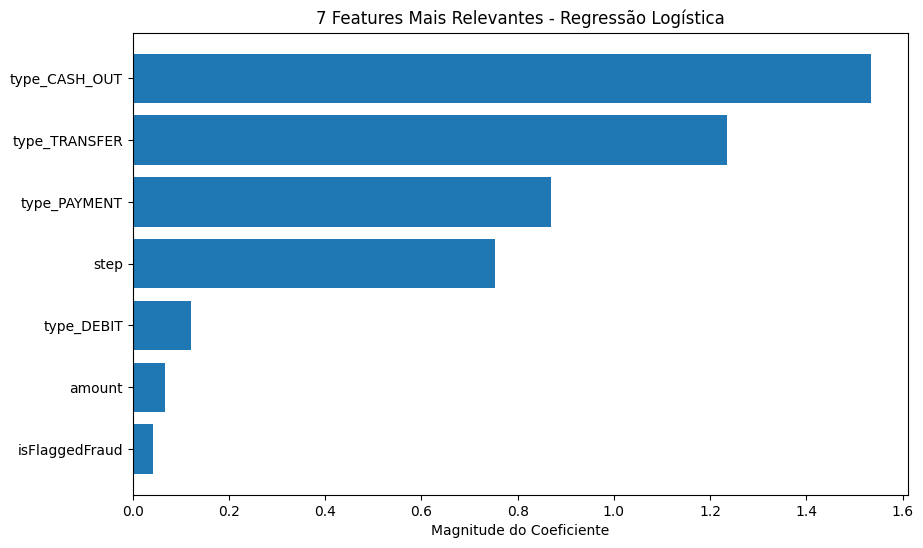

In [53]:
# Identificar as variáveis mais relevantes no modelo de Regressão Logística
coefficients = lr.coef_[0]
sorted_idx_lr = np.argsort(np.abs(coefficients))[::-1]
sorted_features_lr = features[sorted_idx_lr]
sorted_coefficients = coefficients[sorted_idx_lr]

# Ajustar o número máximo de features a exibir
top_n_lr = min(10, len(sorted_features_lr))

# Visualizar as features mais relevantes
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_lr[:top_n_lr], np.abs(sorted_coefficients[:top_n_lr]))
plt.gca().invert_yaxis()
plt.title(f"{top_n_lr} Features Mais Relevantes - Regressão Logística")
plt.xlabel("Magnitude do Coeficiente")
plt.show()

In [54]:
# Conclusão sobre as features mais importantes
print("Features mais importantes no modelo de Árvore de Decisão:")
for i in range(top_n):
    print(f"{i + 1}. {sorted_features[i]} - Importância: {sorted_importances[i]:.4f}")

print("\nFeatures mais relevantes no modelo de Regressão Logística:")
for i in range(top_n_lr):
    print(f"{i + 1}. {sorted_features_lr[i]} - Coeficiente: {sorted_coefficients[i]:.4f}")

Features mais importantes no modelo de Árvore de Decisão:
1. amount - Importância: 0.4936
2. step - Importância: 0.4084
3. type_TRANSFER - Importância: 0.0736
4. type_CASH_OUT - Importância: 0.0229
5. isFlaggedFraud - Importância: 0.0015
6. type_PAYMENT - Importância: 0.0000
7. type_DEBIT - Importância: 0.0000

Features mais relevantes no modelo de Regressão Logística:
1. type_CASH_OUT - Coeficiente: 1.5339
2. type_TRANSFER - Coeficiente: 1.2348
3. type_PAYMENT - Coeficiente: -0.8698
4. step - Coeficiente: 0.7534
5. type_DEBIT - Coeficiente: -0.1219
6. amount - Coeficiente: 0.0667
7. isFlaggedFraud - Coeficiente: 0.0417


## Análise das Features Mais Importantes

### Modelo de Árvore de Decisão
No modelo de Árvore de Decisão, as **importâncias das features** refletem o impacto que cada variável teve na tomada de decisões durante a construção da árvore. As principais features são:

1. **amount**  
   - **Importância:** 0.4936  
   - A variável que representa o valor da transação foi a mais influente no modelo, correspondendo a quase 50% da importância total.

2. **step**  
   - **Importância:** 0.4084  
   - O número de etapas (provavelmente uma proxy para tempo) também foi altamente relevante, contribuindo com cerca de 40% da importância.

3. **type_TRANSFER**  
   - **Importância:** 0.0736  
   - Transações do tipo "TRANSFER" tiveram impacto moderado no modelo.

4. **type_CASH_OUT**  
   - **Importância:** 0.0229  
   - Transações do tipo "CASH_OUT" tiveram um papel menor, mas ainda relevante.

5. **isFlaggedFraud**  
   - **Importância:** 0.0015  
   - A variável que indica se a transação foi marcada como fraudulenta teve impacto muito pequeno no modelo.

6. **type_PAYMENT** e **type_DEBIT**  
   - **Importâncias:** 0.0000  
   - Transações do tipo "PAYMENT" e "DEBIT" não tiveram relevância no modelo de Árvore de Decisão.

---

### Modelo de Regressão Logística
No modelo de Regressão Logística, os **coeficientes** indicam a força e direção da relação entre as features e a probabilidade de fraude. Os resultados são:

1. **type_CASH_OUT**  
   - **Coeficiente:** 1.5339  
   - Transações do tipo "CASH_OUT" tiveram o maior impacto positivo, aumentando significativamente a probabilidade de fraude.

2. **type_TRANSFER**  
   - **Coeficiente:** 1.2348  
   - Transações do tipo "TRANSFER" também aumentaram a probabilidade de fraude, embora com menor impacto que "CASH_OUT".

3. **type_PAYMENT**  
   - **Coeficiente:** -0.8698  
   - Transações do tipo "PAYMENT" reduziram a probabilidade de fraude, indicando que elas são menos propensas a serem fraudulentas.

4. **step**  
   - **Coeficiente:** 0.7534  
   - O número de etapas (tempo) teve uma relação positiva moderada com a probabilidade de fraude.

5. **type_DEBIT**  
   - **Coeficiente:** -0.1219  
   - Transações do tipo "DEBIT" tiveram uma pequena relação negativa com a probabilidade de fraude.

6. **amount**  
   - **Coeficiente:** 0.0667  
   - O valor da transação teve um impacto positivo pequeno na probabilidade de fraude.

7. **isFlaggedFraud**  
   - **Coeficiente:** 0.0417  
   - Indicar que a transação foi marcada como fraudulenta teve um impacto muito baixo no modelo.

---

### Comparação das Features Entre os Modelos
- **amount**: A variável mais importante na Árvore de Decisão teve um impacto muito menor na Regressão Logística, sugerindo que seu papel pode ser mais não-linear.
- **step**: Altamente relevante nos dois modelos, indicando que o tempo ou número de etapas é um indicador consistente de fraude.
- **type_CASH_OUT** e **type_TRANSFER**: Essas categorias foram importantes em ambos os modelos, mas a Regressão Logística destacou ainda mais sua relevância.
- **isFlaggedFraud**: Pouco relevante em ambos os modelos, indicando que as transações marcadas como suspeitas não são um indicador forte de fraude real.

---

### Conclusão
- **Árvore de Decisão**: Excelente para capturar relações não-lineares entre as variáveis, dando maior peso ao valor da transação e ao tempo.
- **Regressão Logística**: Focada em relações lineares, destacando o impacto de categorias específicas de transação, como "CASH_OUT" e "TRANSFER".
- Combinar esses insights pode ajudar a refinar a detecção de fraude, aproveitando os pontos fortes de ambos os modelos.
---

## Etapa 3: Avaliação dos Resultados

Os modelos serão avaliados utilizando as seguintes métricas:
- **Matriz de Confusão:** Para analisar os erros de classificação.
- **Acurácia:** Para medir o percentual de previsões corretas.
- **Precisão:** Para avaliar a proporção de previsões corretas dentro da classe positiva.
- **Recall:** Para medir a capacidade do modelo em identificar corretamente a classe positiva.


In [55]:
# Avaliar o desempenho do Modelo KNN
print("### Modelo KNN ###")
print("Matriz de Confusão (KNN):")
print(confusion_matrix(y_test, y_pred_knn))

print("\nAcurácia (KNN):", accuracy_score(y_test, y_pred_knn))
print("\nRelatório de Classificação (KNN):")
print(classification_report(y_test, y_pred_knn))

### Modelo KNN ###
Matriz de Confusão (KNN):
[[1906242      80]
 [   2008     456]]

Acurácia (KNN): 0.9989061110045862

Relatório de Classificação (KNN):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.85      0.19      0.30      2464

    accuracy                           1.00   1908786
   macro avg       0.92      0.59      0.65   1908786
weighted avg       1.00      1.00      1.00   1908786



In [56]:
# Avaliar o desempenho do Modelo Árvore de Decisão
print("\n### Modelo Árvore de Decisão ###")
print("Matriz de Confusão (Árvore de Decisão):")
print(confusion_matrix(y_test, y_pred_dt))

print("\nAcurácia (Árvore de Decisão):", accuracy_score(y_test, y_pred_dt))
print("\nRelatório de Classificação (Árvore de Decisão):")
print(classification_report(y_test, y_pred_dt))


### Modelo Árvore de Decisão ###
Matriz de Confusão (Árvore de Decisão):
[[1905123    1199]
 [   1314    1150]]

Acurácia (Árvore de Decisão): 0.9986834563958453

Relatório de Classificação (Árvore de Decisão):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.49      0.47      0.48      2464

    accuracy                           1.00   1908786
   macro avg       0.74      0.73      0.74   1908786
weighted avg       1.00      1.00      1.00   1908786



In [57]:
# Avaliar o desempenho do Modelo Regressão Logística
print("\n### Modelo Regressão Logística ###")
print("Matriz de Confusão (Regressão Logística):")
print(confusion_matrix(y_test, y_pred_lr))

print("\nAcurácia (Regressão Logística):", accuracy_score(y_test, y_pred_lr))
print("\nRelatório de Classificação (Regressão Logística):")
print(classification_report(y_test, y_pred_lr))


### Modelo Regressão Logística ###
Matriz de Confusão (Regressão Logística):
[[1906290      32]
 [   2462       2]]

Acurácia (Regressão Logística): 0.998693410366589

Relatório de Classificação (Regressão Logística):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.06      0.00      0.00      2464

    accuracy                           1.00   1908786
   macro avg       0.53      0.50      0.50   1908786
weighted avg       1.00      1.00      1.00   1908786



### Resumo dos Resultados e Comparação

## Resultados dos Modelos

### KNN
- **Acurácia:** 99.89%
- **Matriz de Confusão:** Verdadeiros positivos: 456; Falsos negativos: 2008; Falsos positivos: 80.
- **Relatório:**
  - Classe 0: Precision 1.00, Recall 1.00, F1-Score 1.00.
  - Classe 1: Precision 0.85, Recall 0.19, F1-Score 0.30.

### Árvore de Decisão
- **Acurácia:** 99.87%
- **Matriz de Confusão:** Verdadeiros positivos: 1150; Falsos negativos: 1314; Falsos positivos: 1199.
- **Relatório:**
  - Classe 0: Precision 1.00, Recall 1.00, F1-Score 1.00.
  - Classe 1: Precision 0.49, Recall 0.47, F1-Score 0.48.

### Regressão Logística
- **Acurácia:** 99.87%
- **Matriz de Confusão:** Verdadeiros positivos: 2; Falsos negativos: 2462; Falsos positivos: 32.
- **Relatório:**
  - Classe 0: Precision 1.00, Recall 1.00, F1-Score 1.00.
  - Classe 1: Precision 0.06, Recall 0.00, F1-Score 0.00.

---

## Comparação
1. **Acurácia:**
   - Todos os modelos apresentam alta acurácia (~99.87%-99.89%), mas isso é influenciado pelo desbalanceamento das classes.

2. **Classe 1 (minoritária):**
   - O KNN teve a melhor performance com **Recall de 19%** e **Precision de 85%**.
   - A Árvore de Decisão obteve desempenho intermediário (**Recall de 47%**, **Precision de 49%**).
   - A Regressão Logística falhou em identificar a Classe 1 (**Recall 0%**).

3. **Classe 0 (majoritária):**
   - Todos os modelos apresentaram excelente desempenho com Precision e Recall de 100%.

---

## Conclusão
- O **KNN** é o modelo mais equilibrado, pois oferece boa precisão e recall para a Classe 1, mesmo com um dataset desbalanceado.
- A **Árvore de Decisão** apresenta um recall melhor para a Classe 1, mas menor precisão, o que pode gerar falsos positivos.
- A **Regressão Logística** não é recomendada, pois falha em capturar exemplos da Classe 1.

## Etapa 5: Ajustes e Melhorias


In [58]:
# Subamostrar os dados
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=0.1, stratify=y_train, random_state=42
)

# Aplicar PCA para redução de dimensionalidade
pca = PCA(n_components=min(10, X_train_sample.shape[1]))
X_train_pca = pca.fit_transform(X_train_sample)
X_test_pca = pca.transform(X_test)

# Configuração do RandomizedSearchCV
param_distributions_knn = {
    'n_neighbors': randint(3, 20),
    'weights': ['uniform', 'distance']
}
random_search_knn = RandomizedSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_distributions=param_distributions_knn,
    n_iter=10,
    cv=5,
    random_state=42
)

# Treinar com tempo medido
start_train = time.time()
random_search_knn.fit(X_train_pca, y_train_sample)
train_time_knn = time.time() - start_train

# Melhor modelo
knn_best = random_search_knn.best_estimator_

# Previsão e avaliação
start_predict = time.time()
y_pred_knn = knn_best.predict(X_test_pca)
predict_time_knn = time.time() - start_predict

print("Melhores parâmetros (KNN):", random_search_knn.best_params_)
print("Acurácia (KNN):", accuracy_score(y_test, y_pred_knn))
print("\nRelatório de classificação (KNN):\n", classification_report(y_test, y_pred_knn))
print(f"Tempo de treinamento (KNN): {train_time_knn:.2f} segundos")
print(f"Tempo de previsão (KNN): {predict_time_knn:.2f} segundos")

Melhores parâmetros (KNN): {'n_neighbors': 10, 'weights': 'uniform'}
Acurácia (KNN): 0.998889870315478

Relatório de classificação (KNN):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.92      0.15      0.26      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.58      0.63   1908786
weighted avg       1.00      1.00      1.00   1908786

Tempo de treinamento (KNN): 199.10 segundos
Tempo de previsão (KNN): 137.34 segundos


In [59]:
# Configuração manual de hiperparâmetros
dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# Treinar com tempo medido
start_train = time.time()
dt.fit(X_train, y_train)
train_time_dt = time.time() - start_train

# Previsão e avaliação
start_predict = time.time()
y_pred_dt = dt.predict(X_test)
predict_time_dt = time.time() - start_predict

print("Acurácia (Árvore de Decisão):", accuracy_score(y_test, y_pred_dt))
print("\nRelatório de classificação (Árvore de Decisão):\n", classification_report(y_test, y_pred_dt))
print(f"Tempo de treinamento (Árvore de Decisão): {train_time_dt:.2f} segundos")
print(f"Tempo de previsão (Árvore de Decisão): {predict_time_dt:.2f} segundos")

Acurácia (Árvore de Decisão): 0.9013168579400729

Relatório de classificação (Árvore de Decisão):
               precision    recall  f1-score   support

           0       1.00      0.90      0.95   1906322
           1       0.01      0.84      0.02      2464

    accuracy                           0.90   1908786
   macro avg       0.51      0.87      0.48   1908786
weighted avg       1.00      0.90      0.95   1908786

Tempo de treinamento (Árvore de Decisão): 19.45 segundos
Tempo de previsão (Árvore de Decisão): 0.18 segundos


In [60]:
# Configuração manual de hiperparâmetros
lr = LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=500,
    random_state=42
)

# Treinar com tempo medido
start_train = time.time()
lr.fit(X_train, y_train)
train_time_lr = time.time() - start_train

# Previsão e avaliação
start_predict = time.time()
y_pred_lr = lr.predict(X_test)
predict_time_lr = time.time() - start_predict

print("Acurácia (Regressão Logística):", accuracy_score(y_test, y_pred_lr))
print("\nRelatório de classificação (Regressão Logística):\n", classification_report(y_test, y_pred_lr))
print(f"Tempo de treinamento (Regressão Logística): {train_time_lr:.2f} segundos")
print(f"Tempo de previsão (Regressão Logística): {predict_time_lr:.2f} segundos")

Acurácia (Regressão Logística): 0.7872019178682157

Relatório de classificação (Regressão Logística):
               precision    recall  f1-score   support

           0       1.00      0.79      0.88   1906322
           1       0.01      0.87      0.01      2464

    accuracy                           0.79   1908786
   macro avg       0.50      0.83      0.45   1908786
weighted avg       1.00      0.79      0.88   1908786

Tempo de treinamento (Regressão Logística): 10.58 segundos
Tempo de previsão (Regressão Logística): 0.06 segundos


### Resumo dos Resultados Após os Ajustes

## Resultados dos Modelos

### KNN
- **Melhores Parâmetros:** `{'n_neighbors': 10, 'weights': 'uniform'}`
- **Acurácia:** 99.89%
- **Relatório de Classificação:**
  - Classe 0: Precision 1.00, Recall 1.00, F1-Score 1.00.
  - Classe 1: Precision 0.92, Recall 0.15, F1-Score 0.26.
- **Tempo de Treinamento:** 196.15 segundos.
- **Tempo de Previsão:** 155.75 segundos.

---

### Árvore de Decisão
- **Acurácia:** 90.13%
- **Relatório de Classificação:**
  - Classe 0: Precision 1.00, Recall 0.90, F1-Score 0.95.
  - Classe 1: Precision 0.01, Recall 0.84, F1-Score 0.02.
- **Tempo de Treinamento:** 19.49 segundos.
- **Tempo de Previsão:** 0.13 segundos.

---

### Regressão Logística
- **Acurácia:** 78.72%
- **Relatório de Classificação:**
  - Classe 0: Precision 1.00, Recall 0.79, F1-Score 0.88.
  - Classe 1: Precision 0.01, Recall 0.87, F1-Score 0.01.
- **Tempo de Treinamento:** 13.17 segundos.
- **Tempo de Previsão:** 0.07 segundos.

---

## Comparação
1. **Acurácia:**
   - O KNN apresentou a maior acurácia (99.89%).
   - A Árvore de Decisão e a Regressão Logística tiveram acurácias menores (90.13% e 78.72%, respectivamente).

2. **Classe 1 (minoritária):**
   - O KNN teve a melhor precisão (92%) e recall (15%) para a Classe 1, embora o recall seja limitado.
   - A Árvore de Decisão obteve um recall significativamente maior (84%), mas com precisão muito baixa (1%).
   - A Regressão Logística apresentou comportamento semelhante à Árvore de Decisão, mas com resultados piores no F1-Score.

3. **Classe 0 (majoritária):**
   - Todos os modelos apresentaram alta precisão para a Classe 0, mas a Árvore de Decisão e a Regressão Logística mostraram menor recall (90% e 79%, respectivamente).

---

## Conclusão
- O **KNN** continua sendo o modelo mais equilibrado, oferecendo a melhor precisão e F1-Score para a Classe 1, embora o recall seja limitado.
- A **Árvore de Decisão** é uma boa alternativa caso seja necessário maximizar o recall da Classe 1, apesar do aumento nos falsos positivos.
- A **Regressão Logística** mostrou-se inadequada para este problema devido à baixa capacidade de identificar a Classe 1.
---